# QuakeMigrate example - Icequake detection in Iceland

## Overview:

This notebook shows how to run QuakeMigrate for icequake detection, using a 2 minute window of continuous seismic data from Hudson et al. (2019). Please refer to this paper for details and justification of the settings used.

Here, we detail how to:
1. Create travel-time lookup tables for the example seismometer network
2. Run the detect stage to coalesce energy through time
3. Run the trigger stage to determine events above a threshold value
4. Run the locate stage to refine the earthquake location

We also include an outline of some of the key outputs.

In [14]:
# Import necessary modules:
from pyproj import Proj

import pandas as pd

import QMigrate.io.data as qdata
import QMigrate.io.quakeio as qio
import QMigrate.lut.lut as qlut
import QMigrate.signal.onset.staltaonset as qonset
import QMigrate.signal.pick.gaussianpicker as qpick
import QMigrate.signal.scan as qscan
import QMigrate.signal.trigger as qtrigger

In [15]:
# Set i/o paths:
station_file = "./inputs/iceland_stations.txt"
data_in   = "./inputs/mSEED"
lut_out   = "./outputs/lut/icequake.LUT"
out_path  = "./outputs/runs"
run_name  = "icequake_example"

## 1. Create travel-time lookup tables (LUT)

In [16]:
import QMigrate.lut.create_lut as clut

# Read in station information
stations = qio.stations(station_file)

# Define projections
cproj = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gproj = Proj("+proj=lcc +lon_0=-17.224 +lat_0=64.328 +lat_1=64.32 +lat_2=64.335 +datum=WGS84 +units=m +no_defs")

# Set the parameters for the travel-times lookup table (LUT)
# Cell count (x,y,z); cell size (x,y,z in metres)
lut = qlut.LUT(ll_corner=[-17.24363934275664, 64.31947715407385, -1390.],
               ur_corner=[-17.204348515198255, 64.3365202025144, 1390],
               cell_size=[100., 100., 20.], grid_proj=gproj, coord_proj=cproj)

# Compute for a homogeneous velocity model
vp = 3630
vs = 1833
clut.compute(lut, stations, method="homogeneous", vp=vp, vs=vs)

# Save the LUT
lut.save(lut_out)

Computing homogeneous travel-time lookup table - 1 of 13
Computing homogeneous travel-time lookup table - 2 of 13
Computing homogeneous travel-time lookup table - 3 of 13
Computing homogeneous travel-time lookup table - 4 of 13
Computing homogeneous travel-time lookup table - 5 of 13
Computing homogeneous travel-time lookup table - 6 of 13
Computing homogeneous travel-time lookup table - 7 of 13
Computing homogeneous travel-time lookup table - 8 of 13
Computing homogeneous travel-time lookup table - 9 of 13
Computing homogeneous travel-time lookup table - 10 of 13
Computing homogeneous travel-time lookup table - 11 of 13
Computing homogeneous travel-time lookup table - 12 of 13
Computing homogeneous travel-time lookup table - 13 of 13


## 2. Coalesce the seismic energy through time

In [17]:
# Create a new instance of the MSEED class and set path structure
data = qdata.Archive(station_file=station_file, archive_path=data_in)
data.path_structure(archive_format="YEAR/JD/*_STATION_*")

# Create a new instance of Onset object
onset = qonset.ClassicSTALTAOnset()
onset.p_bp_filter = [10, 125, 4]
onset.s_bp_filter = [10, 125, 4]
onset.p_onset_win = [0.01, 0.25]
onset.s_onset_win = [0.05, 0.5]

# Create a new instance of the SeisScan class
scan = qscan.QuakeScan(data, lut, onset=onset, output_path=out_path, run_name=run_name)

# Set detect parameters
scan.sampling_rate = 500
scan.time_step = 0.75
scan.n_cores = 12

# Defining the start and end times 
starttime = "2014-06-29T18:41:55.0"
endtime   = "2014-06-29T18:42:20.0"

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [18]:
# Run the detect stage to find the coalescence of energy through time:
scan.detect(starttime, endtime)

	DETECT - Continuous Seismic Processing

	Parameters:
		Start time                = 2014-06-29T18:41:55.000000Z
		End   time                = 2014-06-29T18:42:20.000000Z
		Time step (s)             = 0.75
		Number of CPUs            = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500

		Bandpass filter P  = [10, 125, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:53.350000Z - 2014-06-29T18:42:00.750000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 0.656110 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.100000Z - 2014-06-29T18:42:01.500000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 0.784852 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.850000Z - 2014-06-29T18:42:02.250000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 0.753883 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:55.600000Z - 2014-06-29T18:42:03.000000

## 3. Run the trigger stage, to detect and output individual icequakes

nb: We can use the same QuakeScan object here because we are not using a different decimation. If running trigger and locate on grids with different levels of decimation, a new QuakeScan object should be created.

   TRIGGER - Triggering events from coalescence

   Parameters:
         Start time                = 2014-06-29T18:41:55.000000Z
         End   time                = 2014-06-29T18:42:20.000000Z
         Pre/post pad              = 120 s

         Detection threshold       = 1.8
         Marginal window           = 2.75 s
         Minimum repeat            = 6.0 s

         Trigger from normalised coalescence - True

    Reading in scanmseed...
    ...scanmseed data read from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:20.498000Z.

	Warning! No scanmseed data found for pre-pad!
	Warning! No scanmseed data found for post-pad!

    scanmseed read complete.

    Triggering...
    Triggered event 1 of 1

    Plotting triggered events on decimated grid...
    Successfully read .StationAvailability data from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:19.750000Z



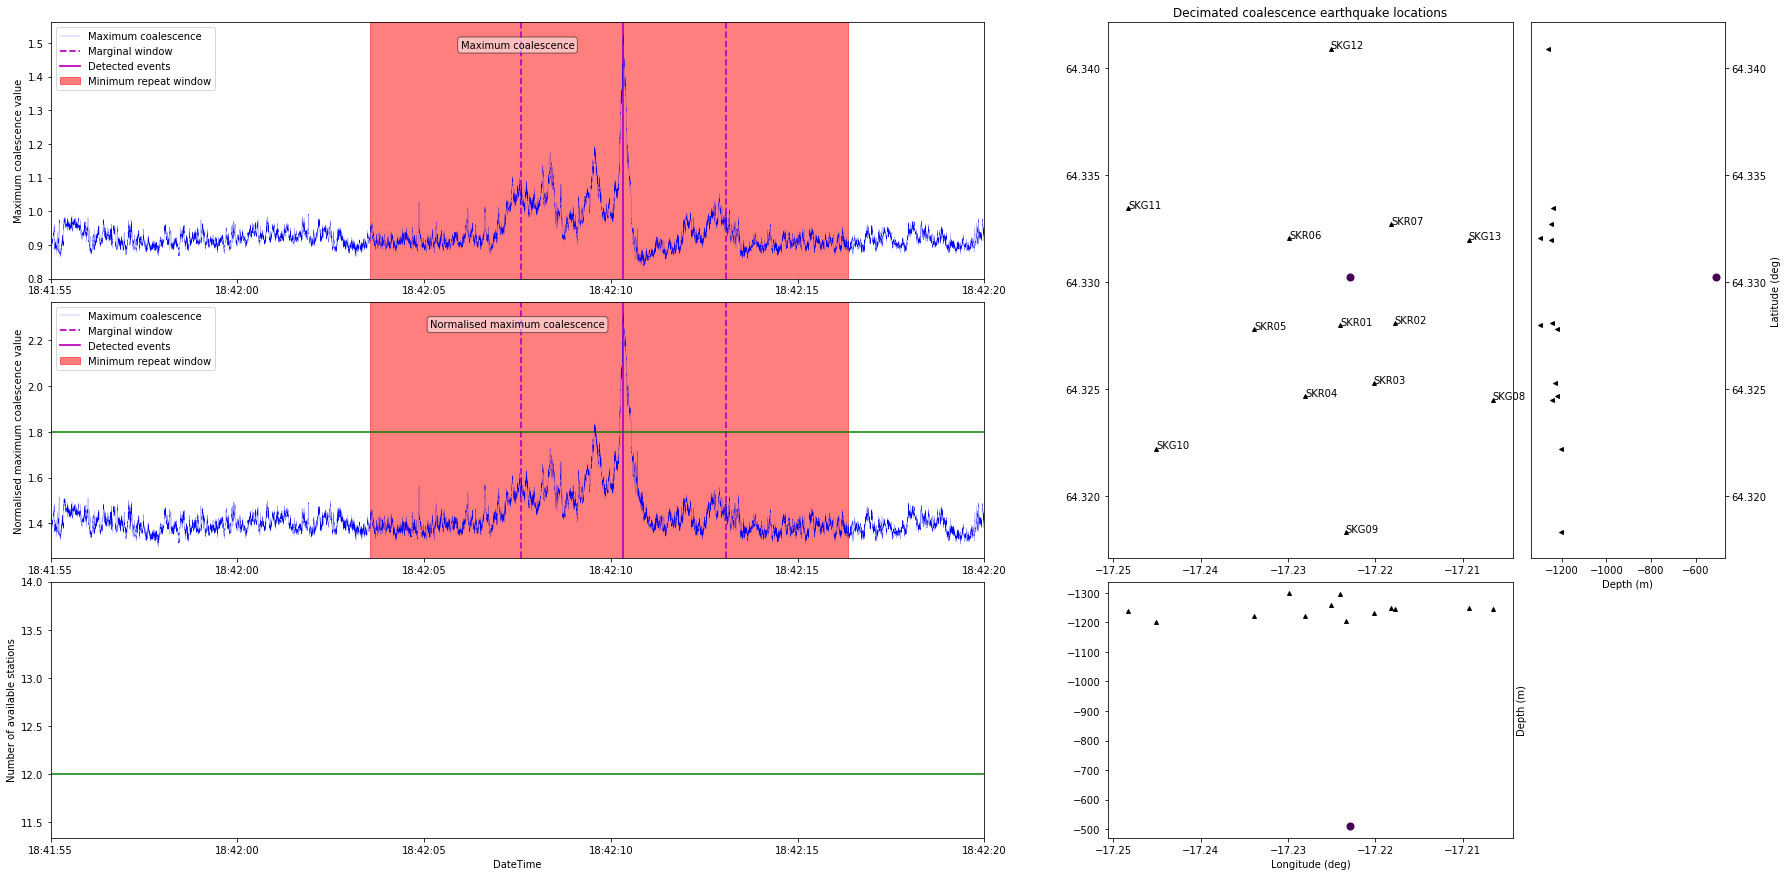

In [19]:
trig = qtrigger.Trigger(out_path, run_name, stations)

trig.normalise_coalescence = True
trig.marginal_window = 2.75
trig.minimum_repeat = 6.
trig.detection_threshold = 1.8

# Run trigger
trig.trigger(starttime, endtime, savefig=True)

## 4. Run the locate stage, to relocate triggered events on a less decimated grid

In [20]:
# Create a new instance of PhasePicker object
picker = qpick.GaussianPicker(onset=onset)
picker.marginal_window = 2.75
picker.plot_phase_picks = True

# Create a new instance of QuakeScan object
scan = qscan.QuakeScan(data, lut, onset=onset, picker=picker,
                       output_path=out_path, run_name=run_name, log=True)

# Set locate parameters:
scan.sampling_rate = 500
scan.marginal_window = 2.75
scan.n_cores = 12

# Turn on plotting features
scan.plot_event_summary = True
scan.plot_event_video = False
scan.write_cut_waveforms = False

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [22]:
# Run the locate stage to determine the location of any triggered events
scan.locate(start_time=starttime, end_time=endtime)

	LOCATE - Determining earthquake location and uncertainty

	Parameters:
		Start time     = 2014-06-29T18:41:55.000000Z
		End   time     = 2014-06-29T18:42:20.000000Z
		Number of CPUs = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500

		Bandpass filter P  = [10, 125, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

	Pick parameters - using the 1-D Gaussian fit to onset
		Pick threshold = 1.0
		Search window  = 0.1s


	EVENT - 1 of 1 - 20140629184210336000

	Determining event location...

	Reading waveform data...
    		Elapsed time: 0.124398 seconds.
	Computing 4D coalescence grid...
    		Elapsed time: 10.717386 seconds.
	Making phase picks...
    		Elapsed time: 0.099340 seconds.
	Determining earthquake location and uncertainty...
		Gridded loc: 10   12   44
		Spline  loc: 10.3 11.7 44.1
    		Elapsed time: 3.163190 seconds.
	Plotting event summary figure...
		Logo not plotting
    		Elap

## 5. Some of the key outputs

In [26]:
# Show the .event file, containing event origin time and location:
icequake_event_fname = "./outputs/runs/icequake_example/events/20140629184210336000.event"
event_df = pd.read_csv(icequake_event_fname)

event_df

,DT,COA,X,Y,Z,LocalGaussian_X,LocalGaussian_Y,LocalGaussian_Z,LocalGaussian_ErrX,LocalGaussian_ErrY,LocalGaussian_ErrZ,GlobalCovariance_X,GlobalCovariance_Y,GlobalCovariance_Z,GlobalCovariance_ErrX,GlobalCovariance_ErrY,GlobalCovariance_ErrZ
0,2014-06-29T18:42:10.336000Z,1.526295,-17.223787,64.328105,44.1,-17.220902,64.330177,-517.661213,163.174285,184.350731,194.447525,-17.22181,64.330231,-502.019418,106.582779,86.554995,119.832768


In [24]:
# Show the .picks file, containing station time picks:
icequake_pick_fname = "outputs/runs/icequake_example/picks/20140629184210336000.picks"
pick_df = pd.read_csv(icequake_pick_fname)

pick_df

,Name,Phase,ModelledTime,PickTime,PickError,SNR
0,SKR01,P,2014-06-29T18:42:10.563542Z,2014-06-29T18:42:10.537238Z,0.012901,2.851287
1,SKR01,S,2014-06-29T18:42:10.786615Z,2014-06-29T18:42:10.763598Z,0.053968,2.095197
2,SKR02,P,2014-06-29T18:42:10.559630Z,2014-06-29T18:42:10.546318Z,0.008995,2.726207
3,SKR02,S,2014-06-29T18:42:10.778868Z,-1,-1.000000,-1.000000
4,SKR03,P,2014-06-29T18:42:10.588888Z,-1,-1.000000,-1.000000
5,SKR03,S,2014-06-29T18:42:10.836809Z,-1,-1.000000,-1.000000
6,SKR04,P,2014-06-29T18:42:10.604714Z,2014-06-29T18:42:10.608155Z,0.009546,2.247718
7,SKR04,S,2014-06-29T18:42:10.868150Z,2014-06-29T18:42:10.905747Z,0.020453,1.633025
8,SKR05,P,2014-06-29T18:42:10.591203Z,2014-06-29T18:42:10.598644Z,0.012307,2.662306
9,SKR05,S,2014-06-29T18:42:10.841394Z,2014-06-29T18:42:10.897415Z,0.057223,2.079614


In [27]:
# Show the coalescence pdf file, containing event origin time and location:
icequake_coal_image_fname = "outputs/runs/icequake_example/summaries/icequake_example_20140629184210336000_EventSummary.pdf"
from IPython.display import IFrame # For plotting pdf
IFrame(icequake_coal_image_fname, width=800, height=400) # Plot pdf

References:

Hudson, T.S., Smith, J., Brisbourne, A.M., and White R.S. (2019). Automated detection of basal icequakes and discrimination from surface crevassing. Annals of Glaciology, 79